In [1]:
import numpy as np
from scipy import special
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
def mixture_sampler(means, covs, p, size=1):
    sample = []
    for _ in range(size):
        i = np.random.choice(np.arange(len(p)), p=p)
        sample.append(np.random.multivariate_normal(mean=means[i], cov=np.diag(covs[i])))
    return np.vstack(sample)

In [3]:
p = torch.tensor([0.5, 0.5])
covs = torch.tensor([[2., 1.],
                       [1., 2.]])
means = torch.tensor([[-2., -3.],
                      [3., 2.,]])

In [4]:
np.random.seed(42)
X = torch.tensor(mixture_sampler(means.numpy(), covs.numpy(), p.numpy(), 1000),
                 dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X[:, 0], 3) * torch.pow(X[:, 1], 2)

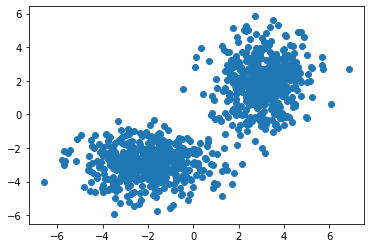

In [5]:
plt.scatter(X.detach()[:, 0], X.detach()[:, 1]);

In [6]:
def Pi_f(means, covs, p):
    Pi_x = torch.pow(means[:, 0], 3) + 3 * means[:, 0] * covs[:, 0]
    Pi_y = covs[:, 1] + torch.pow(means[:, 1], 2)
    return (p * Pi_x * Pi_y).sum().item()
def Log_pi(X, means, covs, p):
    exp = torch.exp(-torch.stack([torch.pow(X - means[i], 2) / (2 * covs[i]) for i in range(len(means))]).sum(dim=-1))
    coefs = p / (2. * np.pi * torch.sqrt(covs.prod(dim=1)))
    return torch.log(torch.matmul(coefs, exp))

In [7]:
pi_f = Pi_f(means, covs, p)
print(pi_f)

8.0


In [14]:
device = 'cpu'
fucking_network = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
    #nn.ReLU(),
    #nn.Linear(32, 2)
)
fucking_network.to(device)
optimizer = torch.optim.Adam(fucking_network.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2000, gamma=0.7)

In [15]:
n_epoch = 22000
Y = (f_X - torch.mean(f_X)).to(device)
loss = nn.MSELoss()
loss_history = []

In [16]:
for _ in tqdm_notebook(range(n_epoch)):
    phi_X = fucking_network(X.to(device))
    X.grad = None
    phi_X[:,0].sum().backward(retain_graph=True)
    phi_prime_X1 = X.grad.to(device)
    X.grad = None
    phi_X[:,1].sum().backward(retain_graph=True)
    phi_prime_X2 = X.grad.to(device)
    div_phi = phi_prime_X1[:, 0] + phi_prime_X2[:, 1]
    log_pi_X = Log_pi(X, means, covs, p).to(device)
    X.grad = None
    log_pi_X.sum().backward(retain_graph=True)
    grad_log_pi_X = X.grad.to(device)
    g_X = (phi_X * grad_log_pi_X).sum(dim=1) + div_phi
    Y_pred = (g_X - torch.mean(g_X)).to(device)
    train_loss = loss(Y_pred, Y).to(device)
    optimizer.zero_grad()
    train_loss.backward(retain_graph=True)
    optimizer.step()
    #scheduler.step()
    loss_history.append(train_loss.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


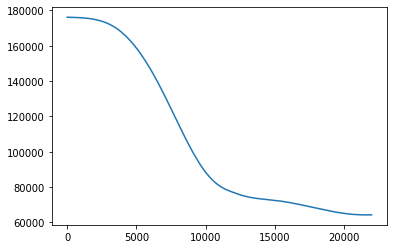

In [17]:
plt.plot(loss_history);

In [18]:
loss_history[-1]

64285.0859375

In [19]:
min(loss_history)

64239.77734375

In [20]:
estimates = []
vr_estimates = []
np.random.seed(42)
for i in tqdm_notebook(range(100)):
    X = torch.tensor(mixture_sampler(means.numpy(), covs.numpy(), p.numpy(), 10000),
                 dtype=torch.float32, requires_grad=True)
    f_X = (torch.pow(X[:, 0], 3) * torch.pow(X[:, 1], 2)).to(device)
    estimates.append(f_X.mean().item())
    phi_X = fucking_network(X.to(device))
    X.grad = None
    phi_X[:,0].sum().backward(retain_graph=True)
    phi_prime_X1 = X.grad.to(device)
    X.grad = None
    phi_X[:,1].sum().backward(retain_graph=True)
    phi_prime_X2 = X.grad.to(device)
    div_phi = phi_prime_X1[:, 0] + phi_prime_X2[:, 1]
    log_pi_X = Log_pi(X, means, covs, p).to(device)
    X.grad = None
    log_pi_X.sum().backward(retain_graph=True)
    grad_log_pi_X = X.grad.to(device)
    g_X = (phi_X * grad_log_pi_X).sum(dim=1) + div_phi
    vr_estimates.append((f_X - g_X).mean().item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


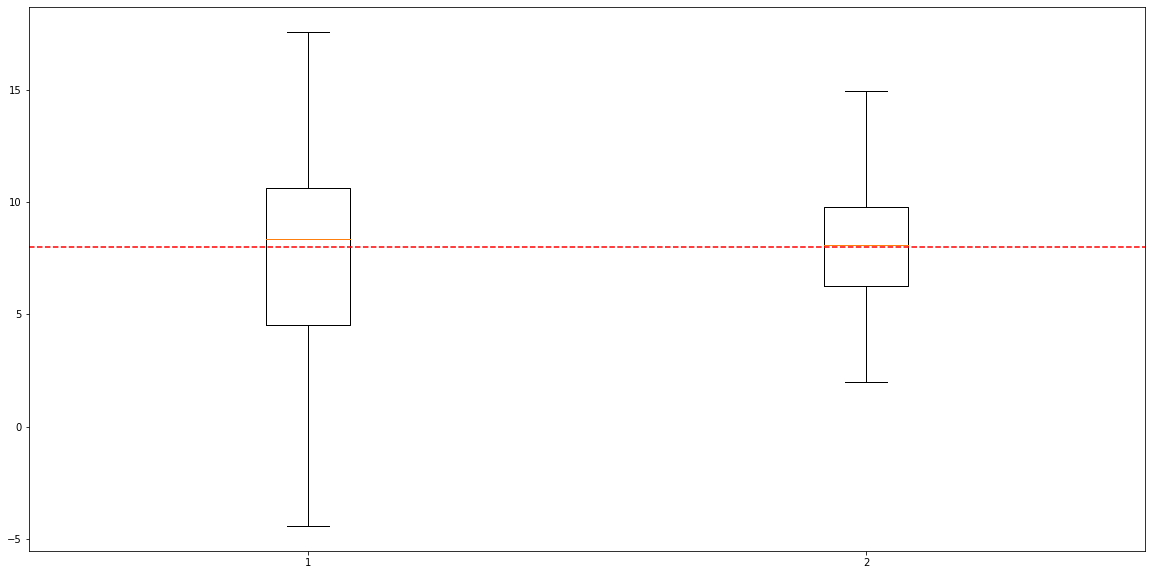

In [21]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates, vr_estimates])
plt.axhline(y=pi_f, color='r', linestyle='--');

In [22]:
np.median(vr_estimates)

8.122109413146973

In [10]:
a = torch.tensor([[3., 1.],[1., 2.], [-2., 0.]])
a

tensor([[ 3.,  1.],
        [ 1.,  2.],
        [-2.,  0.]])

In [11]:
means

tensor([[-2., -3.],
        [ 3.,  2.]])

In [12]:
Q = torch.stack([torch.pow(a - means[i], 2) for i in range(len(means))]).sum(dim=-1)
Q

tensor([[41., 34.,  9.],
        [ 1.,  4., 29.]])

In [13]:
b = torch.tensor([3., 1.])
b @ Q

tensor([124., 106.,  56.])

In [ ]:
np.var(f_X.cpu().detach().numpy())

181950.55

In [ ]:
np.var(vr_estimates)

6.732851086066155

In [ ]:
np.var(estimates)

17.873109075818316